### Training a Single-Shot-Detector model to detect palm trees in aerial imagery

In [3]:
# Importing necessary ArcGIS Python API tools:

from arcgis.learn import SingleShotDetector, prepare_data

Since this is a deep learning model, for all the demonstrations we need data. That's why `prepare_data` function is being imported. The function reads the data from a directory in the format exported by the ArcGIS Pro or `export_training_data` function in `arcgis.learn` module. On calling this function with valid parameters it returns a `fast.ai` `DataBunch` object, which can be used by our `SingleShotDetector` class.

This function accepts a required argument i.e data path, which is just a string containing the path to directory where the chips and labels were extracted. The directory structure should look like this.

`data/
----images/
----labels/`

The second required argument is a `class_mapping` dictionary which maps the integer labels in the xml file to a string. This argument is just for visualization purposes.

The other important parameter is `chip_size` which specifies the size of the image that will be passed to the model. The current settings of this parameter is set in such a way that a random 224 sized crop is taken from the original image, i.e. we exported 448x448 sized images and will be randomly cropping out 224x224 sized chips from it as additional augmentation during training.

In [4]:
# This is the path to the training examples exported by 
# the [Export Training Data for Deep Learning] Geoprocessing tool in ArcGIS Pro:

data_path = r'C:\deep-learning-lab\palmtree_house_training_samples'

In [5]:
# Loading the data, using default split of 90 / 10 for Training and Validation.
# The second parameter allows for specifying text labels for the classes.

data = prepare_data(data_path, {1:'Palm', 2:'House'}) #for 448x448, single class training samples

In [6]:
# Checking on the classes loaded with the data:
data.classes

['background', 'House', 'Palm']

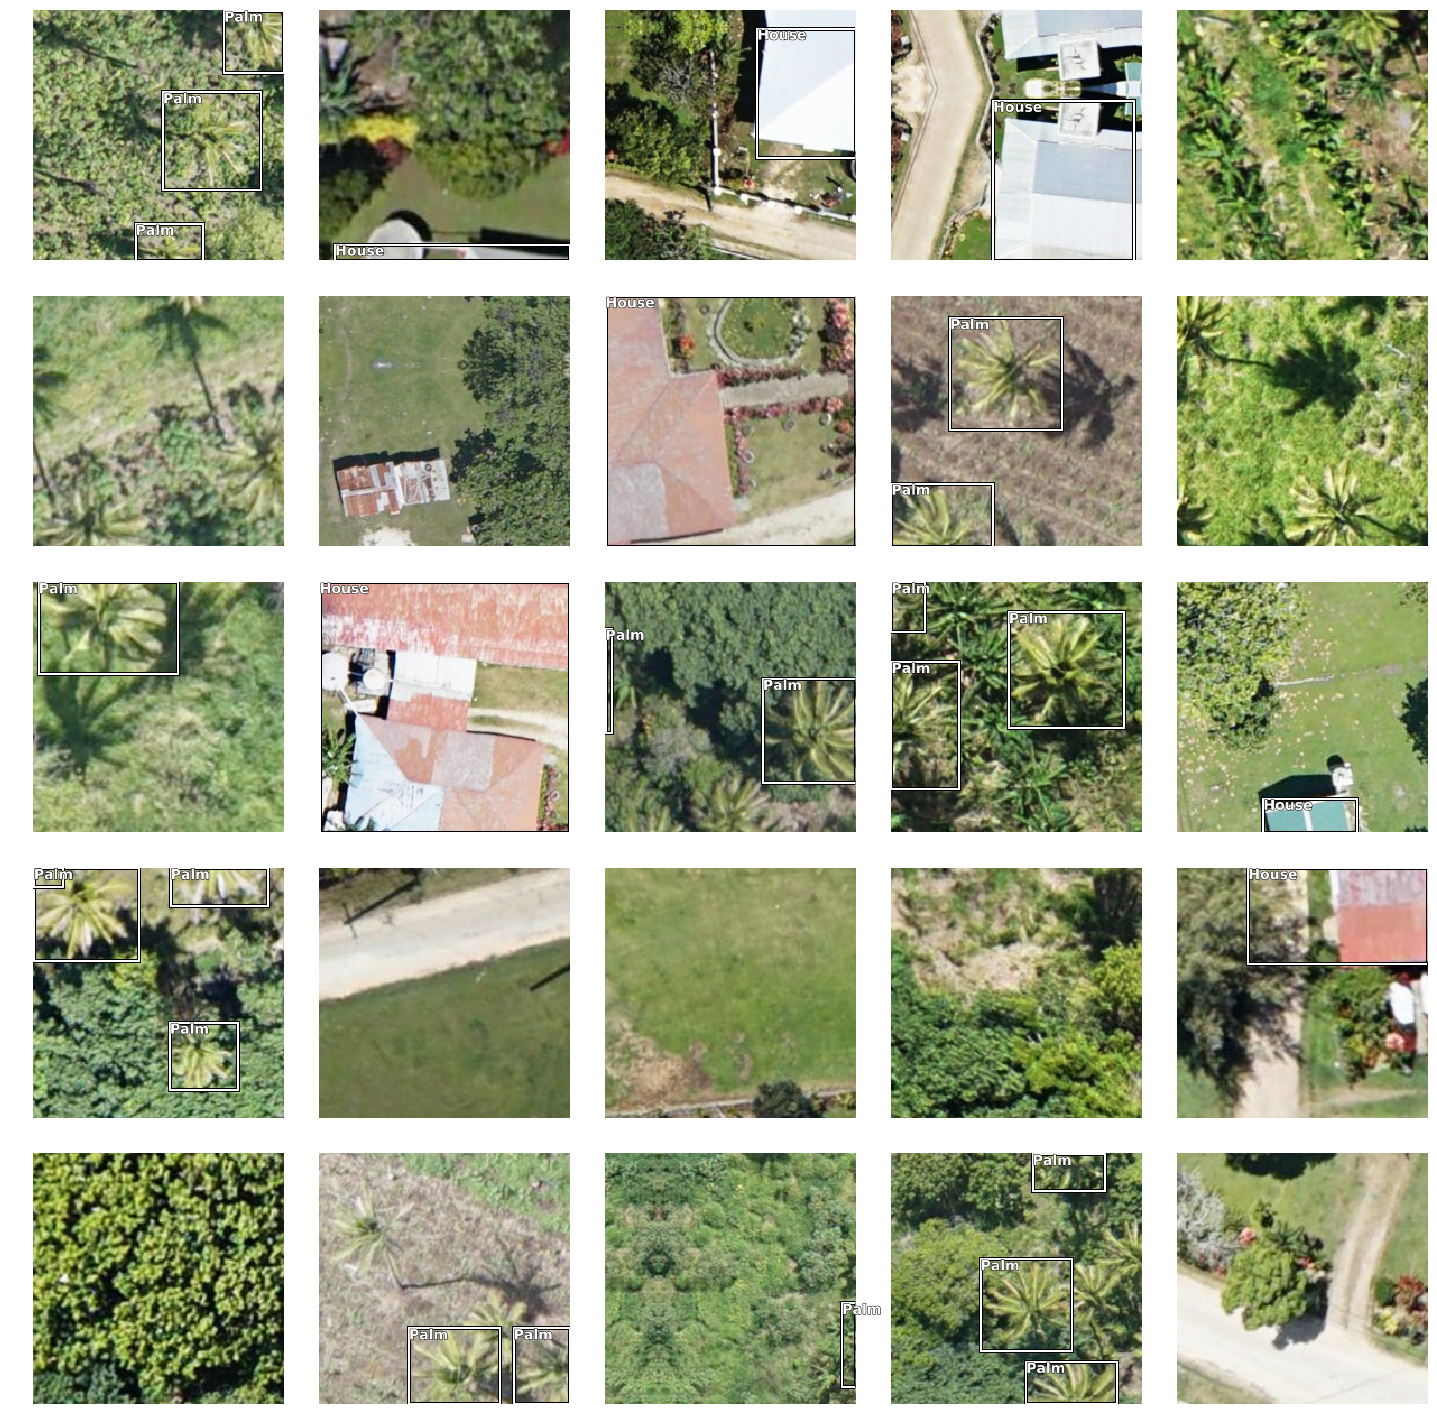

In [7]:
# Visualize a random batch from the training set to 
# make sure the data is loaded correctly and ready for training:

data.show_batch()

#### Simple SSD: Constructor

The `SingleShotDetector` class contains classes and functions to build the architecture as specified in its constructor. For every different class definition there is a seperate architecture that is build internally. The object of this class can be used to train the model, see the results and save the model and its Esri model definition(emd) file. 

There are three main parameters which defines a `SingleShotDetector` namely Grids, Zooms and Ratios. Let's go step by step and learn what how these three parameter modify the architecture.

**Grids :** This defines in how many grids our image will be divided into. So, suppose we have this parameter set to `[4]`, it will divide the image in 4x4 grids. Let's call each cell of the grid a grid cell. The 4x4 grid we will have 16 grid cells responsible for prediction of bounding boxes. Similiarly, if we set it to `[2]` the image will be divided into a 2x2 grid and then 4 grid cells will be responsible for detecting objects. Now if we pass a list like in default constructor of `SingleShotDetector` i.e `[4,2,1]`. The image will be divided into each of those grids and a total of 21(16 + 4 + 1) grid cells will be responsible for detecting objects.

**Zooms :** This defines in how many zoom levels each grid cell will be scaled up or down depending on the number that we pass. If we pass `[1]`, all the grid cells will remain of same size. If we pass `[2]` all the grid cells will become twice as large. If we pass a list as in the default `SingleShotDetector` all the grid cells will be scaled using all the numbers in the list. It means all the 21 grid cells of the `[4,2,1]` grid will be scaled by `[0.7,1.0,1.3]` these numbers making a total of 63 (21 * 3) anchor boxes. We will now call these scaled versions of grid cells anchor boxes, which are responsible for detecting objects.

**Ratios :** These ratios define the aspect ratio of the anchor box. So its a list of list, if its like `[[1,1]]`, this means that the anchor box is a square. If its like `[[1, 0.5]]` then the anchor box will become a vertical rectangle with it width halved and height doubled. In default scenario i.e `[[1.0, 1.0], [1.0, 0.5], [0.5, 1.0]]`, the earlier 63 anchor boxes will be made this way and a total of 189 (63 * 3) anchor boxes will be created and will be responsible for detecting objects.

The **backbone** parameter is a torchvision pretrained model to be used as a backbone for `SingleShotDetector` head. We will not be experimenting with this parameter during this exercise: the backbone in our case is "frozen". 

In [24]:
# Instantiating Single Shot Detector model:
ssd = SingleShotDetector(data, grids=[4], zooms=[1.0], ratios=[[1.0, 1.0]])

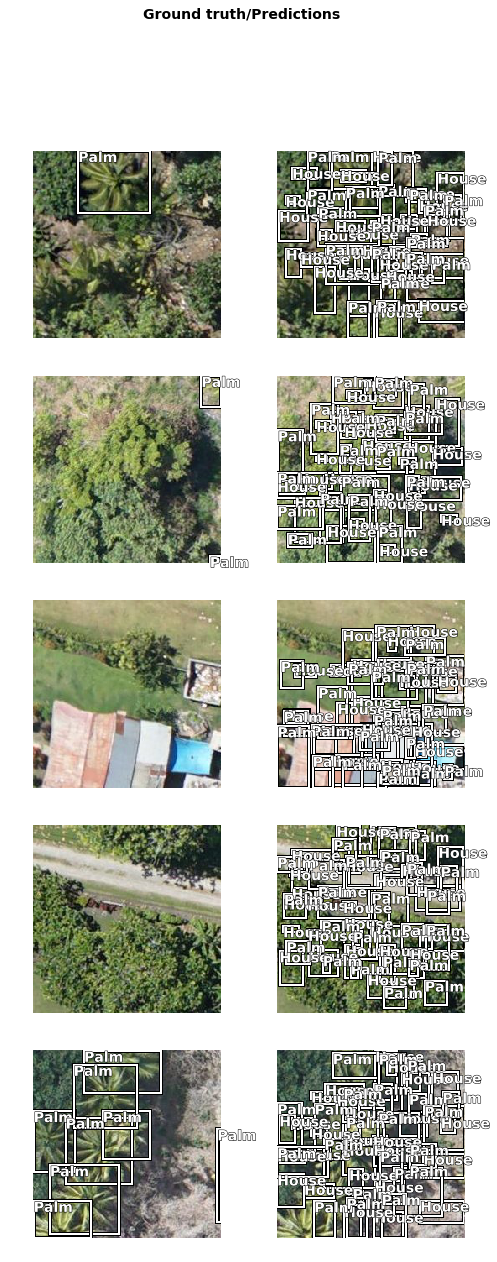

In [9]:
# What does the SSD model output when it has not been trained yet?
# Note randomly looking detection boxes in the right column.
ssd.show_results(thresh=0.2)

#### Simple SSD: Training

Let's call one of the SSD's object functions named the `lr_finder`, which can be used to tune the most important hyperparameter in deep learning models - the learning rate. By inspecting the resulting graph we can select a good learning rate value: we are looking for a maximum learning rate where the slope of the graph is still going down. 

A good blogpost describing how lr_find works: https://towardsdatascience.com/estimating-optimal-learning-rate-for-a-deep-neural-network-ce32f2556ce0


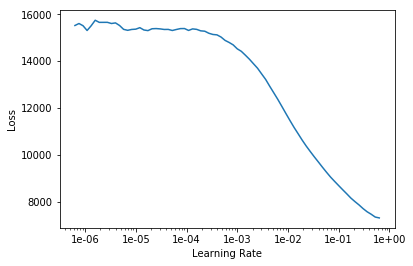

In [10]:
# Let us use the Learning Rate Finder utility to determine 
# the optimal learning rates for the Backbone and the Head of SSD:

ssd.lr_find()

Let's perform the actual training of the model, and then inspect the training and validation loss graphs.

Overfitting?
If the validation loss graph starts consistently going up, we may have overtrained (overfitted) the model. If the validation loss keeps going down or stays stable, there is still may be a room for improvement.

Training the Head only: Transfer Learning.
Since we are limited in time here, to speed up the process of training, we will be training only a subportion of the SSD network, which is directly responsible for the detection and classification of our target object classes. The "Backbone" portion of the SSD remains "frozen" with weights pretrained on ImageNet dataset. 
If we had more time and samples to train on, it would be worthwhile to experiment and see if training of the backbone may also improve the detection results. To train the backbone, call `ssd.unfreeze()` before actual training.

In [25]:
# Train the model for the specified number of epochs and using the specified learning rates 
# for the Backbone (first lr parameter, not used since backbone is frozen)
# and the Head (second lr parameter - you need to specify a good value here):

# Hint: you can keep training ssd through multiple iterations, calling `ssd.fit(50,...)`, then `ssd.fit(100,....)` again, etc.
# For this task, the total number of epochs to train ssd to an accepatable quality should not be much greater than 300.
# If you want to start training from scratch, just call the SinGleShotDetector constructor again.
# You can also re-start training from a particular checkpoint - see comments below on `ssd.save()`.

ssd.fit(30, lr=slice(1e-5, 1)) #TODO: looking at the lr_find() chart above, specify a good learning rate for the SSD's Head 

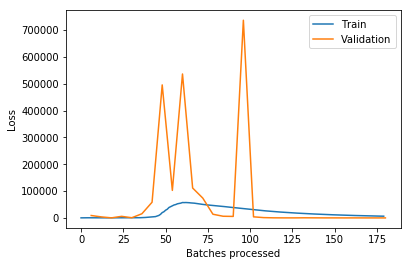

In [26]:
# Once the initial training is complete, let us examine 
# how the loss function on Training and Validation sets looks - 
# are there signs of overfitting? or can we keep training?

ssd.learn.recorder.plot_losses()

In [27]:
# What is the average precision score for the detections at this point?
# Does it keep going up after additional epochs of training?
ssd.average_precision_score() 

{'House': 0.23076924395102738, 'Palm': 0.3706159982688426}

In [28]:
# Once the model is trained to a certain accuracy, it can be saved locally - a "checkpoint".
# A saved model can be used in ArcGIS Pro for local inferencing, or uploaded to Portal for ArcGIS to become an inferencing service.
# You may also want to save intermediate checkpoints between iterations of training, so you can return back to one 
# in case the next portion of training epochs takes the model in a wrong direction, e.g. network starts overfitting the training set.
# To load ssd from a checkpoint: ssd = SingleShotDetector.from_emd(data, r'<path_to_emd_file>')

ssd.save('myHouseModel_e30_3') # Name your model. You may want to add number of epochs trained to the name, e.g. "myModel_e150"

Created model files at C:\deep-learning-lab\palmtree_house_training_samples\models\myHouseModel_e30_3


In [58]:
# ssd = SingleShotDetector.from_emd(data, r'C:\deep-learning-lab\palmtree_training_samples\models\myModel_e200')

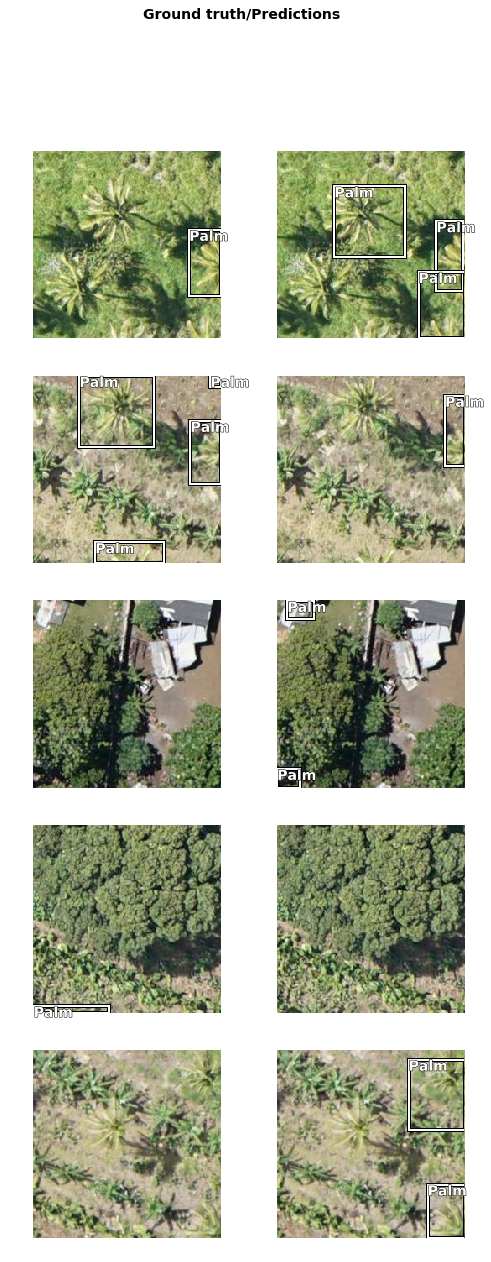

In [59]:
# So, how does the output of the model which was trained for NNN epochs change?

ssd.show_results(thresh=0.5)

# Will the accuracy improve, if you train for additional epochs? 
# Go back to the cell containging ssd.fit(...) above, and run it again for additional epochs of training.
# Once trained for additional epochs, run the loss function chart cell:
#   - is loss function still going down?
#   - any signs of overfitting?
# Don't forget to save a checkpoint.

# Your Observations

### TODO:

#### Task 1. For Palms detections:
write one or two paragraphs below about:
- What was the best Validation Loss value?
- Did you see signs of overfitting?
- What is the best Average Precision you have achieved?
- General thoughts on the process, and about good and bad detections.

Using `lr_finder` we found the best Validation Loss value to be somewhere around` 42.1`. This value was found using an epoch of 250. We came close to this value using epochs of 30, 100, 200, and 300, but 250 seemed to provide us with the best (lowest)absolute Validation Loss value. We did not see any signs of overfitting with our various Single Shot Detector where the loss graph consistently increases. Using the epochs that we did, we saw one of two things occur. Either (1) the loss graph reached a slight peak around 200 batches or (2) the loss graph reached a severe peak at around 200 batches but remained stable otherwise. We saw the latter phenomenon occur with our higher epochs (>200). 

The Average Precision scores that we came up with were as follows:

| epoch         | Average Precision |
| ------------- |:-----------------:|
| 30            | .402              |
| 100           | .413              |
| 200           | .503              |
| 225           | .477              |
| 250           | .653              |
| 300           | .498              |

From the table above, you can see that the best Average Precision we received was `0.653` which was found using an epoch of 250. This whole process was interesting. The one gripe we have is how long it took to fit our model with the higher epochs. Finding 30 and 100 were fairly painless, but the longer downtime became a bit of a burden especially with the limited amount of time alotted to complete the project.

#### Task 3. For Palms and Houses detections:
- What is the best Average Precision per each class you have achieved with a single model?
- How did you configure the model and why: grids, zooms, ratios.
- How did you train the model?: # of epochs, iterations, learning rate changes, etc.
- If you had more time to work on this project, which steps would you take to train a model to a better quality?



The following test cases are listed below for future reference. Each test case used 30 epochs:

###### Test Case 1

* grids=[6,4,2]
* zooms=[0.5,1.0,1.5]
* ratios=[[1.0, 1.0], [1.0, 0.5], [0.5, 1.0]]
* learning rate: 0.5

* Results:
    * {'House': 0.48851150863773185, 'Palm': 0.14623746731241094}
    
###### Test Case 2

* grids=[4]
* zooms=[1.0]
* ratios=[[1.0, 1.0]]
* learning rate: 0.5

* Results:
    * {'House': 0.42377624363749167, 'Palm': 0.3340481373963473}
    
###### Test Case 3

* grids=[4]
* zooms=[1.0]
* ratios=[[1.0, 1.0]]
* learning rate: 0.7

* Results:
    * {'House': 0.5897436124137325, 'Palm': 0.2598987476458188}
    
###### Test Case 4

* grids=[4]
* zooms=[1.0]
* ratios=[[1.0, 1.0]]
* learning rate: 1.0

* Results:
    * {'House': 0.23076924395102738, 'Palm': 0.3706159982688426}
    
The best Average Precision we recived for the `House` and `Palm` classes are listed below:

* `House`: 0.590
* `Palm` : 0.371

When configuring the model we took a few things into account. For grids, we chose three seperate values due to the discrepancy in both shape and size of houses and palm trees. We thought more grids would better identify palm trees and large grids would be able to label houses more easily. We had a similar mindset for the zoom levels. By zooming out you can see the full extent of a house, but you may not be able to see that same house in full when viewing a palm tree close up. Lastly, by changing up ratios we thought we could better idetify houses due to the fact that not all houses are of the same shape and oriented in the same direction as each other.

If we were alotted more time on this project we would most definetely train our model on a higher number of epochs. We had success using a larger number when attempting to analyze palm trees, but with the large amount of time it took to run these models it was not feasible to do so with two variables. Additionally, we would've liked to toy around with more expansive model configurations in order to see which ones worked the best and go on to understand why.